In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_oscillation

from timescales.pipe import Pipe
from timescales.conversions import convert_knee
from timescales.sim import sim_spikes_prob, sim_synaptic_kernel

from timescales.plts import set_default_rc
set_default_rc()

# 06. Pipes

Pipe objects provide a unified class to simulate stochastic signals, compute PSD and/or ACF, fit models, and extract timecales. These objects may be initialize with an array of random seeds for reproducible results. This allows various simulation and quantification methods to be compared to one another.

Pipes are specificed using the `add_step` method, follow by a step string argument:

1. `simulate` followed by a simulation function argument that accepts n_seconds and fs as the first two poistionals, follow by an arbitary number of keyword arguments supported by the function

  1a. `sample` may used to sample spikes from a continuous simulation and to upsample the the continuous function by specifiying a larger sampling frequency, `fs`.
  
  1b. `bin` may be used to bin spikes together.
  
  
2. `transform` followed by either `PSD` or `ACF` and additionally supported keyword arguements.


3. `fit` followed by a list of supported attributes to return along with fit keyword arguements. For a list of attributes and supported kwargs, see the PSD and ACF classes in the timescales.fit.

In [2]:
# Initialize a pipeline
n_seconds = 2
fs = 5000
seeds = np.arange(100)

pipe = Pipe(n_seconds, fs, seeds)

## Simulation

Multiple simulation method calls may be used to flexibly combine signals. The sample method allows sampling spikes from a probability distribution and also also probability upsampling for faster spike simulations. The bin method called last to sum spikes every five samples.

In [3]:
tau =  convert_knee(10)
kernel = sim_synaptic_kernel(10 * tau, fs, 0, tau)


# Simulation Steps
pipe.add_step('simulate', sim_spikes_prob, kernel, rescale=(0, .9))
pipe.add_step('simulate', sim_oscillation, 10, rescale=(0, .1))
pipe.add_step('sample')
pipe.add_step('bin', 5)

## Transform

The transform method is used to transform a time series into either a PSD or ACF. A number of tranforms may be sequentially stacked, each to be ran on the same simulations.

In [4]:
# Welch's PSD
pipe.add_step('transform', 'PSD')

# AR PSD
pipe.add_step('transform', 'PSD', ar_order=100)

# ACF from Welch's PSD
pipe.add_step('transform', 'ACF', nlags=200, from_psd=True)

# ACF from AR PSD
pipe.add_step('transform', 'ACF', nlags=200, from_psd=True, psd_kwargs={'ar_order': 100})

## Fit

A fit call for each transform can be added to the pipeline. A single fit call may be added to the pipeline if all of the transforms are of the same type.

In [5]:
pipe.add_step('fit', ['knee_freq', 'rsq', 'tau'], method='cauchy')
pipe.add_step('fit', ['knee_freq', 'rsq', 'tau'], method='cauchy')
pipe.add_step('fit', ['knee_freq', 'rsq', 'tau'])
pipe.add_step('fit', ['knee_freq', 'rsq', 'tau'])

## Run

The pipeline may be excute in parallel.

In [6]:
# Run pipeline
pipe.run(progress='tqdm.notebook', n_jobs=-1)

Fitting Timescales:   0%|          | 0/100 [00:00<?, ?it/s]

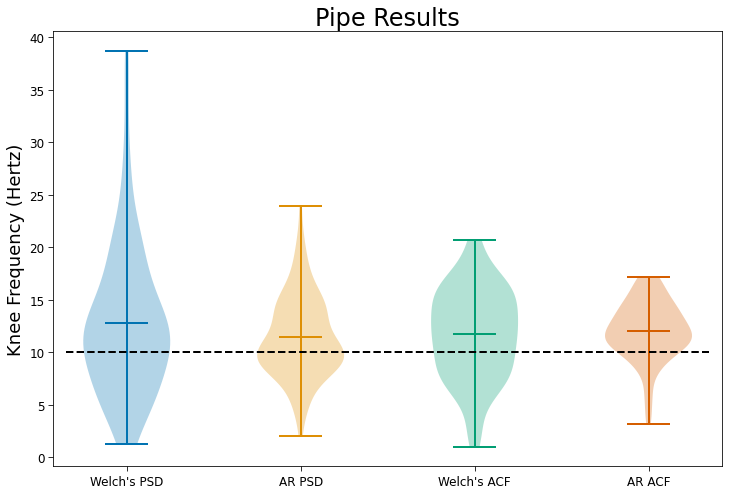

In [7]:
plt.figure(figsize=(12, 8))

plt.violinplot(pipe.results[:, 0, 0], positions=[1], showmeans=True)
plt.violinplot(pipe.results[:, 1, 0], positions=[2], showmeans=True)
plt.violinplot(pipe.results[:, 2, 0], positions=[3], showmeans=True)
plt.violinplot(pipe.results[:, 3, 0], positions=[4], showmeans=True)


plt.axhline(10, .02, .98,  color='k', ls='--', label='Truth')

labels = ['Welch\'s PSD',  'AR PSD', 'Welch\'s ACF', 'AR ACF']
plt.xticks([1, 2, 3, 4], labels=labels)

plt.ylabel('Knee Frequency (Hertz)')
plt.title('Pipe Results');